# TODO: 
Determine optimal values of k and an optimal set of attributes to use to maximize predictive power in predicting if a patient has heart disease or not. (The dataset has a "num" attribute. You will want to collapse all values 1-4 into a single value so that "num" is boolean.) Report your prediction results using the precision, recall, and F1 metrics (list all ten scores). Also report your k value and the set of attributes you are using. You must use sklearn.model_selection.train_test_split randomly to split your data. You must also use at least 10 iterations of cross-validation. For simplicity, you may use Monte Carlo cross-validation, but for just a bit more of a challenge, you can use 10-fold cross-validation. See this tutorialLinks to an external site. for more information. For your chosen approach to model fitting you should report all precision/recall/F1 scores as well as the mean F1 score. You may report additional scores for other models if it sheds light on your final result.

# Predict if a student is a graduate or dropout

Using this database: https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success 

array([ 68, 455, 265, 451, 198, 334, 440, 201], dtype=int64)

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
86,1,39,1,9670,1,1,120.0,1,1,19,...,0,5,7,5,11.600000,0,9.4,-0.8,-3.12,Graduate
555,1,44,1,9003,1,39,150.0,1,3,2,...,3,9,13,6,10.857143,0,15.5,2.8,-4.06,Dropout
314,1,51,1,9147,1,1,135.0,1,1,1,...,0,5,5,0,0.000000,0,11.1,0.6,2.02,Dropout
551,1,39,1,9773,1,19,133.1,1,19,1,...,0,6,9,4,13.750000,0,12.7,3.7,-1.70,Dropout
238,1,1,1,9130,1,1,126.0,1,19,1,...,0,5,10,4,14.250000,0,9.4,-0.8,-3.12,Dropout
409,4,39,1,9085,1,1,133.1,1,34,34,...,0,5,5,0,0.000000,0,7.6,2.6,0.32,Dropout
534,1,44,1,171,1,39,150.0,1,4,4,...,0,0,0,0,0.000000,0,15.5,2.8,-4.06,Graduate
243,1,39,1,9147,1,1,120.0,1,37,1,...,0,5,9,0,0.000000,0,10.8,1.4,1.74,Dropout


Graduates: 2
Dropouts: 6


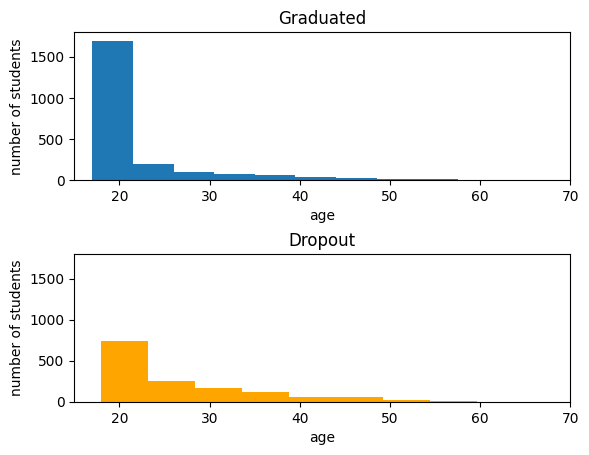

In [122]:
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
import random

# Load the data
data = pd.read_csv('data.csv', delimiter=';')

# Remove students who are only enrolled
data = data[data['Target'] != 'Enrolled']
data.columns = data.columns.str.rstrip()
data.head()

dataGraduate = data[data['Target'] == 'Graduate']
dataDropout = data[data['Target'] == 'Dropout']

# Make a histogram based on age
fig, (ax1, ax2) = plt.subplots(2, 1)
# Make a little extra space between the subplots
fig.subplots_adjust(hspace=0.5)

ax1.hist(dataGraduate['Age at enrollment'])
ax1.set_xlabel('age')
ax1.set_ylabel('number of students')
ax1.set_xlim(15, 70)
ax1.set_ylim(0, 1800)
ax1.set_title('Graduated')

ax2.hist(dataDropout['Age at enrollment'], color='orange')
ax2.set_xlabel('age')
ax2.set_ylabel('number of students')
ax2.set_xlim(15, 70)
ax2.set_ylim(0, 1800)
ax2.set_title('Dropout')

# Use knn on age. First create a nearest neighbors object.
nn = NearestNeighbors(n_neighbors=8, metric='euclidean', algorithm='auto')

# Create a two-dimensional array. This is basically a one-dimensional array with
# single-element arrays of patient ages in the second dimension. We're going to
# search for neighbors using only the age dimension.
X = [[x] for x in data['Age at enrollment']]

# This builds an index data structure under the hood for query performance
fit = nn.fit(X)

# Find the k nearest neighbors
distances, indices = fit.kneighbors([[25]])
display(indices[0])

# Get the students that are near the age
nbrs = data.iloc[indices[0]]
display(nbrs)

# Print how many students are graduates and how many are dropouts
graduates = nbrs[nbrs.Target == 'Graduate'].count().Target
dropouts = nbrs[nbrs.Target == 'Dropout'].count().Target
print('Graduates: {}\nDropouts: {}'.format(graduates, dropouts))


In [123]:
X = data[['Age at enrollment', 'Admission grade']].values
y = data[['Target']].values

# This builds an index data structure under the hood for query performance
fit = nn.fit(X)

# Get a random student to test on
i = random.randint(0, len(X)-1)
studentX = X[i]
studenty = y[i]
display(data.iloc[i])

# Find the k nearest neighbors to the student.
# Problem: the student theirself is also included in the nearest neighbors!
distances, indices = fit.kneighbors([studentX])
nbrs = data.iloc[indices[0]]
display(nbrs)

graduated = nbrs[nbrs.Target == 'Graduate'].count().Target
dropout = nbrs[nbrs.Target == 'Dropout'].count().Target
print('Graduates: {}\nDropouts: {}'.format(graduated, dropout))
predict = 0 if (graduated > dropout) else 1
actual = 0 if (studenty == 'Graduate') else 1
success = predict == actual
print(success)

Marital status                                            1
Application mode                                         17
Application order                                         2
Course                                                 9500
Daytime/evening attendance                                1
Previous qualification                                    1
Previous qualification (grade)                        125.0
Nacionality                                               1
Mother's qualification                                   19
Father's qualification                                   19
Mother's occupation                                       5
Father's occupation                                       5
Admission grade                                       114.5
Displaced                                                 1
Educational special needs                                 0
Debtor                                                    0
Tuition fees up to date                 

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
1612,1,17,2,9500,1,1,125.0,1,19,19,...,0,8,12,8,12.281250,0,16.2,0.3,-0.92,Graduate
3129,1,1,1,9773,1,1,121.0,1,1,38,...,0,6,6,6,12.833333,0,11.1,0.6,2.02,Graduate
444,1,17,1,9670,1,1,123.0,1,19,19,...,0,5,5,4,11.000000,0,9.4,-0.8,-3.12,Graduate
3980,1,17,6,9238,1,1,117.0,1,1,38,...,0,6,6,6,13.333333,0,13.9,-0.3,0.79,Graduate
2161,1,17,2,9670,1,1,123.0,1,34,37,...,0,5,6,4,10.750000,0,7.6,2.6,0.32,Dropout
1009,1,17,3,9670,1,1,122.0,1,1,38,...,0,6,7,6,13.714286,0,11.1,0.6,2.02,Graduate
3885,1,18,1,9238,1,1,122.0,1,38,38,...,0,6,8,6,12.000000,0,11.1,0.6,2.02,Graduate
3191,1,1,1,9670,1,1,115.0,1,19,37,...,0,6,6,4,13.000000,0,12.4,0.5,1.79,Dropout


Graduates: 6
Dropouts: 2
True


In [124]:
from sklearn.metrics import precision_recall_fscore_support


data['Age at enrollment Standardized'] = (data['Age at enrollment'] - data['Age at enrollment'].mean()) / data['Age at enrollment'].std()
data['Admission grade Standardized'] = (data['Admission grade'] - data['Admission grade'].mean()) / data['Admission grade'].std()

X = data[['Age at enrollment Standardized', 'Admission grade Standardized']].values
y = data[['Target']].values

# This builds an index data structure under the hood for query performance
fit = nn.fit(X)

# Get random students to test on
n = 7
pindices = [random.randint(0,len(X)-1) for _ in range(n)]
studentsX = X[pindices]
studentsy = y[pindices]

# Find the k nearest neighbors to the student.
# Problem: the student theirself is still being included!
distances, indices = fit.kneighbors(studentsX)
print('indices of k-nearest neighbors for each student:')
display(indices)

# added these vv
successes = 0

for i in range(n):
    print('nearest neighbors to student: {}:'.format(studentsX[i]))
    nbrs = data.iloc[indices[i]]
    # display(nbrs)
    # I ADDED BELOW:
    graduated = nbrs[nbrs.Target == 'Graduate'].count().Target
    dropout = nbrs[nbrs.Target == 'Dropout'].count().Target
    print('Graduates: {}\nDropouts: {}'.format(graduated, dropout))
    predict = 0 if (graduated > dropout) else 1
    actual = 0 if (studenty == 'Graduate') else 1
    success = predict == actual
    successes += success
    print(success)

# Compile how many patients are predicted correctly.
print('Success rate: {}'.format(successes/n))

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)#, random_state=42)
# (p,r,f,s) = precision_recall_fscore_support(y_test, y_pred, labels=[1])


indices of k-nearest neighbors for each student:


array([[ 425,  405, 2782, 2908,  461,  556, 3112,  234],
       [2020,  351,  247, 1331,  113, 1073,  679, 2133],
       [2733, 3251,  986, 3257, 2028, 2218,  430,  119],
       [2047,  821, 2540, 2009, 3627, 2907, 1398, 1534],
       [3190,   92, 2850, 2088, 2883,  858, 3426, 3607],
       [ 741, 2609, 3331,  767, 1838, 1613,  687,  983],
       [ 172, 1712, 3554, 2363, 1721,   87,  894, 2118]], dtype=int64)

nearest neighbors to student: [-0.05891126 -0.29387808]:
Graduates: 6
Dropouts: 2
True
nearest neighbors to student: [-0.56989784 -0.43075848]:
Graduates: 5
Dropouts: 3
True
nearest neighbors to student: [-0.4421512   0.32208374]:
Graduates: 6
Dropouts: 2
True
nearest neighbors to student: [0.9630619  1.55400737]:
Graduates: 4
Dropouts: 4
False
nearest neighbors to student: [-0.69764449 -0.37600632]:
Graduates: 6
Dropouts: 2
True
nearest neighbors to student: [-0.56989784 -1.34101317]:
Graduates: 4
Dropouts: 4
False
nearest neighbors to student: [-0.69764449  0.59584455]:
Graduates: 8
Dropouts: 0
True
Success rate: 0.7142857142857143


In [128]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

k = 50
nn = NearestNeighbors(n_neighbors=k+1, metric='euclidean', algorithm='auto')  # +1 to exclude the student themselves

# Standardize the features
data['Age at enrollment Standardized'] = (data['Age at enrollment'] - data['Age at enrollment'].mean()) / data['Age at enrollment'].std()
# data['Admission grade Standardized'] = (data['Admission grade'] - data['Admission grade'].mean()) / data['Admission grade'].std()
# data['GDP Standardized'] = (data['GDP'] - data['GDP'].mean()) / data['GDP'].std()
data['Previous qualification (grade) Standardized'] = (data['Previous qualification (grade)'] - data['Previous qualification (grade)'].mean()) / data['Previous qualification (grade)'].std()
# data['Curricular units 1st sem (grade) Standardized'] = (data['Curricular units 1st sem (grade)'] - data['Curricular units 1st sem (grade)'].mean()) / data['Curricular units 1st sem (grade)'].std()
data['Curricular units 2nd sem (grade) Standardized'] = (data['Curricular units 2nd sem (grade)'] - data['Curricular units 2nd sem (grade)'].mean()) / data['Curricular units 2nd sem (grade)'].std()
data['Unemployment rate Standardized'] = (data['Unemployment rate'] - data['Unemployment rate'].mean()) / data['Unemployment rate'].std()
data['Inflation rate Standardized'] = (data['Inflation rate'] - data['Inflation rate'].mean()) / data['Inflation rate'].std()
data['Curricular units 2nd sem (enrolled) Standardized'] = (data['Curricular units 2nd sem (enrolled)'] - data['Curricular units 2nd sem (enrolled)'].mean()) / data['Curricular units 2nd sem (enrolled)'].std()
# data['Curricular units 1st sem (enrolled) Standardized'] = (data['Curricular units 1st sem (enrolled)'] - data['Curricular units 1st sem (enrolled)'].mean()) / data['Curricular units 1st sem (enrolled)'].std()
# data['Curricular units 1st sem (evaluations) Standardized'] = (data['Curricular units 1st sem (evaluations)'] - data['Curricular units 1st sem (evaluations)'].mean()) / data['Curricular units 1st sem (evaluations)'].std()
# data['Course Standardized'] = (data['Course'] - data['Course'].mean()) / data['Course'].std()
# data['Previous qualification (grade) Standardized'] = (data['Previous qualification (grade)'] - data['Previous qualification (grade)'].mean()) / data['Previous qualification (grade)'].std()

# X = data[['Age at enrollment Standardized', 'Admission grade Standardized']].values
# X = data[['Admission grade Standardized', 'GDP Standardized', 'Previous qualification (grade) Standardized', 'Age at enrollment Standardized', 'Curricular units 1st sem (grade) Standardized', 'Unemployment rate Standardized']].values

# .559, .0959
X = data[['Unemployment rate Standardized', 'Curricular units 2nd sem (grade) Standardized', 'Inflation rate Standardized']].values

# .36, 0.05
# X = data[['Unemployment rate Standardized', 'Curricular units 2nd sem (grade) Standardized', 'Inflation rate Standardized', 'Curricular units 2nd sem (grade) Standardized', 'Previous qualification (grade) Standardized', 'Age at enrollment Standardized']].values

# Precision: .61764706, Recall: 0.06104651
# X = data[['Unemployment rate Standardized', 'Curricular units 2nd sem (grade) Standardized', 'Inflation rate Standardized', 'Curricular units 2nd sem (enrolled) Standardized']].values

y = data['Target'].values

# Monte Carlo cross-validation parameters
n_iterations = 10
test_size = 0.25

precision_scores = []
recall_scores = []
f1_scores = []

for i in range(n_iterations):

    # Use random_state if you want the same values each time you run for debugging,
    # but you should select the split randomly when you're ready to actually train
    # and test on the data.

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25) #, random_state=42)

    # Fit the model with the training data
    fit = nn.fit(X_train)

    # Find the k nearest neighbors for the test set
    # You get ___ distances, and ___ indices 
    distances, indices = fit.kneighbors(X_test)
    # print('Indices of k-nearest neighbors for each test sample:')
    # print(indices)

    y_pred = []
    for j in range(len(X_test)):
        # Exclude the student theirself by taking the next k neighbors
        nbrs = data.iloc[indices[j][1:]]
        # nbrs = data.ilocp[indices[i]]
        graduated = nbrs[nbrs.Target == 'Graduate'].count().Target
        dropout = nbrs[nbrs.Target == 'Dropout'].count().Target
        predict = 'Dropout' if (dropout > graduated) else 'Graduated'
        y_pred.append(predict)

    # Calculate precision, recall, and F1-score
    (p,r,f,s) = precision_recall_fscore_support(y_test, y_pred, labels=['Dropout'])
    precision_scores.append(p[0])
    recall_scores.append(r[0])
    f1_scores.append(f[0])
    print(f"Iteration {i}: Precision: {p}, Recall: {r}, F1-Score: {f}, Support: {s}")

# Calculate the average precision, recall, and F1-score
avg_precision = np.mean(precision_scores)
avg_recall = np.mean(recall_scores)
avg_f1 = np.mean(f1_scores)

print(f"Average Precision: {avg_precision}, Average Recall: {avg_recall}, Average F1-Score: {avg_f1}")

# We care most about recall here
# _or_ relax the condition we're using for precision here
# so change it to this, to predict a lot more people as being sick:
# predict = 'Dropout' if (dropout > 0) else 'Graduated'
# That's kind of a bad approach though. You could boost recall by adding more variables.
# You could also change k. 

# You can use gridsearch. What's that? a function or a database?

# Just say: this is what we expected, this is what we tried, here were the roadblocks we ran into, etc. No need to find a new database :) thanks profe!

Iteration 0: Precision: [0.], Recall: [0.], F1-Score: [0.], Support: [358]
Iteration 1: Precision: [0.50724638], Recall: [0.09831461], F1-Score: [0.16470588], Support: [356]
Iteration 2: Precision: [0.63934426], Recall: [0.1086351], F1-Score: [0.18571429], Support: [359]
Iteration 3: Precision: [0.47916667], Recall: [0.06571429], F1-Score: [0.11557789], Support: [350]
Iteration 4: Precision: [0.40384615], Recall: [0.06], F1-Score: [0.10447761], Support: [350]
Iteration 5: Precision: [0.58], Recall: [0.08077994], F1-Score: [0.14180929], Support: [359]
Iteration 6: Precision: [0.59375], Recall: [0.05263158], F1-Score: [0.09669211], Support: [361]
Iteration 7: Precision: [0.42857143], Recall: [0.025], F1-Score: [0.04724409], Support: [360]
Iteration 8: Precision: [0.53125], Recall: [0.08994709], F1-Score: [0.15384615], Support: [378]
Iteration 9: Precision: [0.48387097], Recall: [0.04143646], F1-Score: [0.07633588], Support: [362]
Average Precision: 0.4647045855932861, Average Recall: 0.0

### Curse of dimensionality
"In low-dimensional datasets, the closest points tend to be much closer than average. But two points are close only if they're close in every dimension, and every extra dimension -- even if just noise -- is another opportunity for each point to be further away from every other point. When you have a lot of dimensions it's likely that the closest points aren't much closer than average, which means that two points being close doesn't mean very much (unless there is a *lot* of structure in your data)." -Joel Grus

The chart that this code displays shows that distance has less meaning as dimensions grows. In higher dimensions, most points are about the same distance from each other.


[0.5753266399540313, 0.6263534649379995, 0.3998863855517183]
[0.9217788759117552, 0.433996370400552, 1.0487095373209065, 0.5734042914071459, 1.0876211935612339, 0.604430230832783, 0.7563039246844141, 0.4580372875906406, 0.750271804614201, 0.6769659249118162]


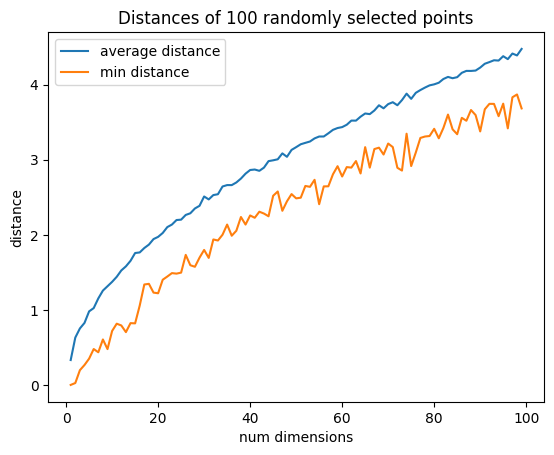

In [50]:
import random
import math

def random_point(dim):
    return [random.random() for _ in range(dim)]

def sq(x):
    return x*x

def distance(a, b):
    a = [sq(a[i] - sq(b[i])) for i in range(len(a))]
    return math.sqrt(sum(a))

def random_distances(dim, num_pairs):
    return [distance(random_point(dim), random_point(dim)) for _ in range(num_pairs)]

print(random_point(3))
print(random_distances(3, 10))

num_pairs = 100
means = []
mins = []
for dim in range(1, 100):
    d = random_distances(dim, num_pairs)
    means.append(sum(d)/len(d))
    mins.append(min(d))

# Note that the ratio of average distance to min distance
# appraoches one, so there's less space between the two.
plt.plot(range(1, 100), means, label='average distance')
plt.plot(range(1, 100), mins, label='min distance')
plt.xlabel('num dimensions')
plt.ylabel('distance')
plt.title('Distances of 100 randomly selected points')
plt.legend()